In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

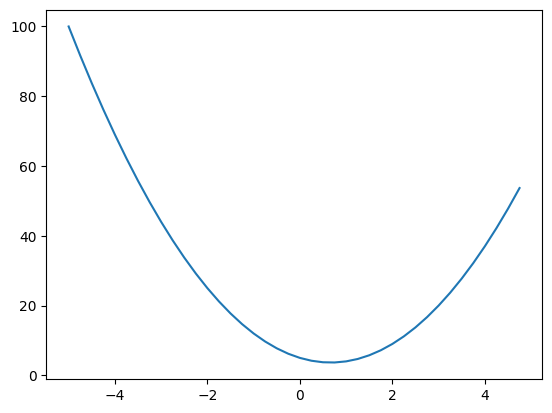

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
x = 2/3
h = 0.00000001
(f(x+h) - f(x))/h

0.0

In [6]:
h = 0.0001
# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [7]:
d1 = a*b + c
b += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 3.999699999999999
d2 3.99990001
slope 2.0001000000124947


In [8]:
d1 = a*b + c
c += h
d2 = a*b + c
print('d1',d1)
print('d2',d2)
print('slope', (d2-d1)/h)

d1 3.99990001
d2 4.00000001
slope 0.9999999999976694


In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    def get_data(self):
        return self._data

    def set_data(self, data):
        if not isinstance(data, (int, float)):
            raise TypeError("Temperature must be a number.")
        self._data = data

    data = property(get_data, set_data)    

    def __repr__(self):
        return f"Value(label={self.label},data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), '+')

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), '*')


In [10]:
from graphviz import Digraph

def draw_dot(root):
    def trace(root):
        # builds a set of all nodes and edges in the graph
        nodes, edges = set(), set()
        def build(v):
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
        build(root)
        return nodes, edges
    
    dot = Digraph(format='svg',graph_attr={'rankdir': 'LR'}) # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular ('record') node for it
        dot.node(name=uid, label = "{ %s | data: %.4f | grad: %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operataion, create an op node for it
            name = uid + n.op
            dot.node(name = name, label = n.op)
            dot.edge(name, uid)
    for e1, e2 in edges:
        # connect e1 to the op node of e1
        dot.edge(str(id(e1)), str(id(e2)) + e2.op)
    return dot

In [11]:
def verify_derivative():
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0 + h, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
verify_derivative()

-1.9999999999988916


In [12]:
# what is the derivative of L with regards to f
# 
# derivative func: (f(x+h)-f(x))/h
# (f(d+h)*f-d*f)/h
# (d*f + h*f - d*f)/h
# (h*f)/h = f

In [13]:
h = 0.0001
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label='f')
#
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'

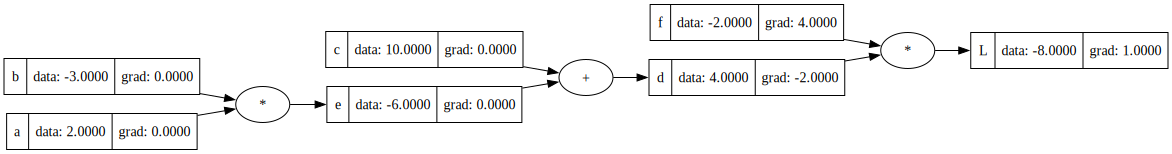

In [14]:
# grads
L.grad = 1.0
d.grad = f.data
f.grad = d.data
draw_dot(L)

In [15]:
# derivative of L with respect to c
# first we find the derivative of d with respect to c
# what is dd/dc
# if d = c + e
# going back to: (f(x+h)-f(x))/h
# ((c + e + h) - (c + e))/h
# (c + e + h - c + e)/h
# h/h = 1.0 
# and by symetry, dd/de = 1.0
print(((c.data + h + e.data) - (c.data + e.data))/h)
# we know the derivative of L with respect to d
# we can use the chain rule (https://en.wikipedia.org/wiki/Chain_rule)
# we know dL/dd = -2.0
# we know dd/dc = 1.0
# so, dL/dc = dL/dd (-2.0) * dd/dc (1.0)
print(((c.data + h + e.data) - (c.data + e.data))/h * d.grad)
# essentially a + node passes the derivative and by symetry also e
c.grad = -2.0
e.grad = -2.0

0.9999999999976694
-1.9999999999953388


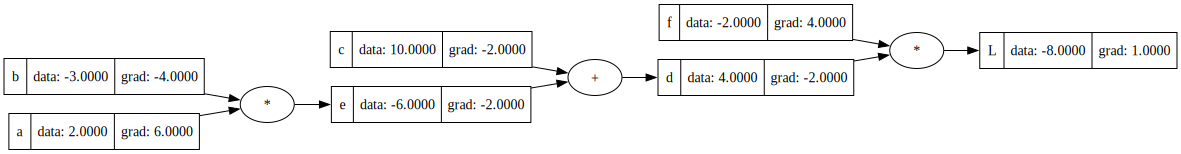

In [16]:
# now we want dL/da
# (dl/de) * (de/da) # local gradient
# 
# if e = a*b
# so what is de/da?
# same as the derivative of L with regards to f, for a multiply node, 
# b.grad = a.data and a.grad = b.data
b.grad = (a.data * e.grad)
a.grad = (b.data * e.grad)
draw_dot(L)

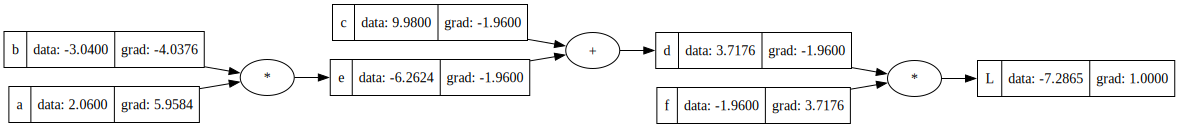

In [17]:
# update leaf nodes' data and expect L to go up in a positive direction
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
#
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f; L.label = 'L'
L.grad = 1.0
# 
d.grad = L.grad * f.data
f.grad = L.grad * d.data
# c local grad
c.grad = 1.0 * d.grad
e.grad = 1.0 * d.grad
#
b.grad = (a.data * e.grad)
a.grad = (b.data * e.grad)
draw_dot(L)
draw_dot(L)

In [56]:
import math


class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    @property
    def backward(self):
        return self._backward

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    def get_data(self):
        return self._data

    def set_data(self, data):
        if not isinstance(data, (int, float)):
            raise TypeError("Temperature must be a number.")
        self._data = data

    data = property(get_data, set_data)

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        v = other if isinstance(other, Value) else Value(other, label=str(other))
        out = Value(self.data + v.data, (self, v), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            v.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):  # reverse multiply
        return self * other

    def __mul__(self, other):
        v = other if isinstance(other, Value) else Value(other, label=str(other))
        out = Value(self.data * v.data, (self, v), '*')

        def _backward():
            self.grad += v.data * out.grad
            v.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other ** -1)

    def __pow__(self, other):
        v = other if isinstance(other, Value) else Value(other, label=str(other))
        out = Value(self.data * v.data, (self, v), '**')

        def _backward():
            self.grad += v.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

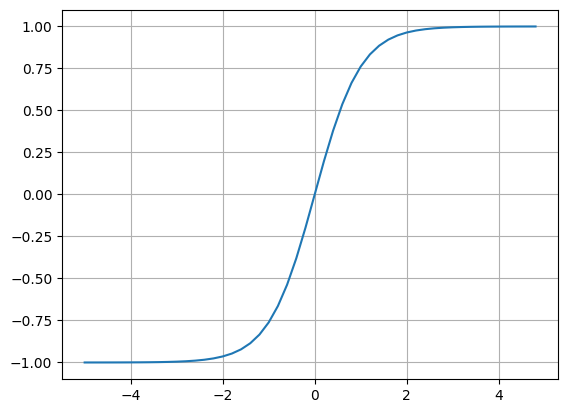

In [19]:
# tanh activation function
r = np.arange(-5,5,0.2)
plt.plot(r, np.tanh(r)); plt.grid();

In [20]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#output
o = n.tanh(); o.label = 'o'; o.grad = 1.0

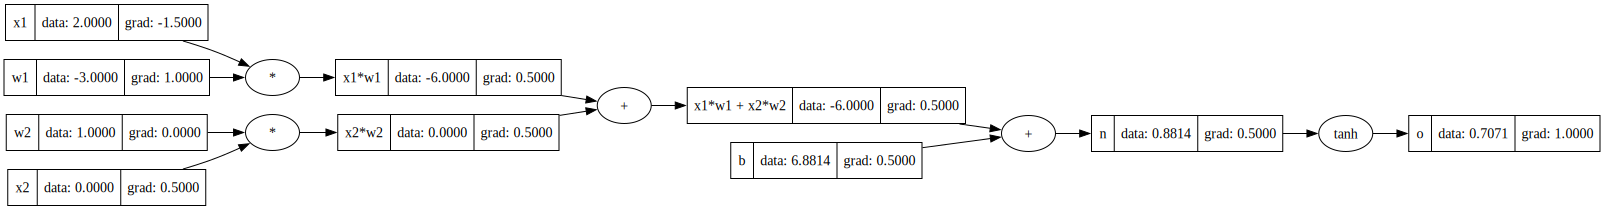

In [21]:
# o = tanh(n)
# what is do/dn? (derivative of o over derivative of n)
#   do/dn -> 1 - tanh(n)**2 => 1 - o**2
grad = 1 - o.data**2
n.grad = grad
# + sign distributes the grad
x1w1x2w2.grad = grad
b.grad = grad
# continuing backward, another + sign
x1w1.grad = grad
x2w2.grad = grad
# continuing backward, we have a * sign
w1.grad = x1.data * x1w1.grad
x1.grad = w1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
draw_dot(o)

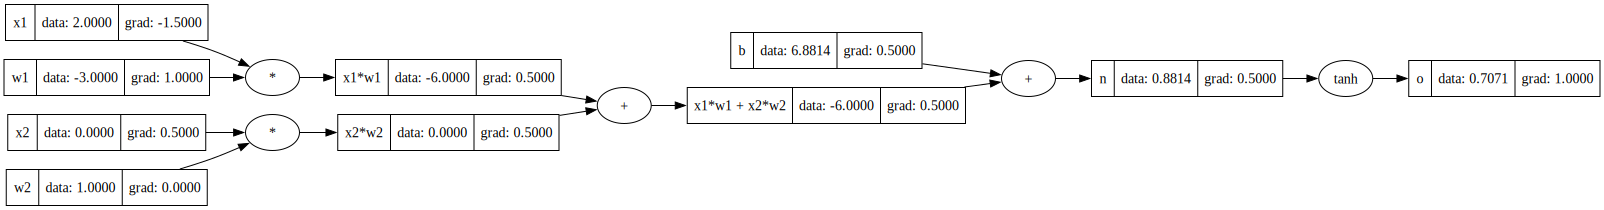

In [88]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#output
o = n.tanh(); o.label = 'o'; o.grad = 1.0
o.backward()
draw_dot(o)

In [91]:
import math


class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self._data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None

    @property
    def backward(self):
        return self._backward

    @property
    def prev(self):
        return self._prev

    @property
    def op(self):
        return self._op

    def get_data(self):
        return self._data

    def set_data(self, data):
        if not isinstance(data, (int, float)):
            raise TypeError("Temperature must be a number.")
        self._data = data

    data = property(get_data, set_data)

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label}, grad={self.grad})"

    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        return self * other ** -1

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)

    def __radd__(self, other):  # other + self
        return self + other

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad  # NOTE: in the video I incorrectly used = instead of +=. Fixed here.

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


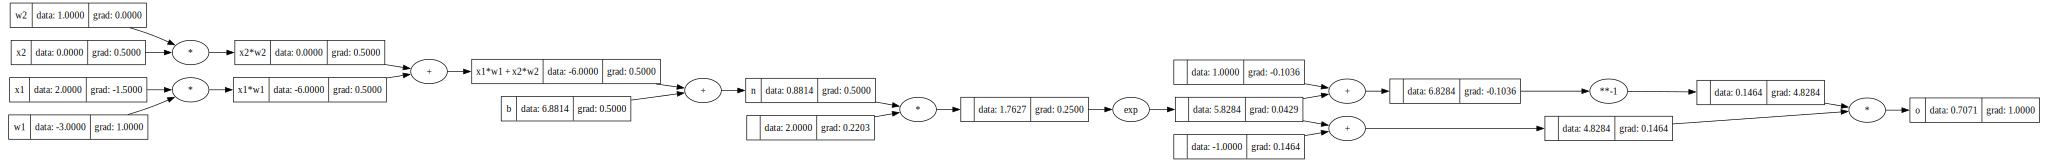

In [92]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)